In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn import metrics
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### **WORK IN PROGRESSSSSSS**

### **DATASETS**

In [ ]:
DATA_SETS_LINKS = {
    
"CARD_FRAUD":"creditcard.csv", #CLassififcation,
}

ALGORITHMS = {
    "XGBOOST":"XGBOOST",
    "RANDOM_FOREST":"RANDOM_FOREST",
    "LINEAR_REGRESSION":"LINEAR_REGRESSION",
    "LOGISTIC_REGRESSION":"LOGISTIC_REGRESSION",
    "VOTING_REGRESSION":"VOTING_REGRESSION"
}

#Dimesionality Reduction & Feature Selection Mapping
DR = {
    "PCA":"PCA",
    "LDA":"LDA",
    "TSNE":"TSNE",
    "L1":"L1", #Logistic Regression
    "RF":"RF", #Random Forest
    "XG":"XG", #XGBoost
    "RFS":"RFS", #Recursive Feature Selection
}


#This function downloads file from google drive and returns the Dataframe Object
def get_dataframe(file_link):
  print(f'downloading data set from:{file_link}')
  url_1 = file_link.replace('/edit#gid=', '/export?format=csv&gid=')
  df = pd.read_csv(url_1)
  df.dropna(axis=0,inplace=True)
  print(df.describe())
  print(df.shape)
  return df


def read_dataframe_from_drive(name_path):
  print(f'Reading data set from Drive:{name_path}')
  df = pd.read_csv(name_path)
  df.dropna(axis=0,inplace=True)
  print(df.describe())
  return df




In [ ]:
df = read_dataframe_from_drive(DATA_SETS_LINKS["CARD_FRAUD"])

Reading data set from Drive:creditcard.csv
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


# **EDA - CARD FRAUD DETECTION**

# **Class Distribution**

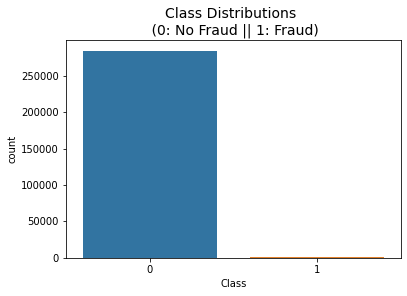

In [ ]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

**Distributions**: As we can see from histogram, the distribution is skewed and biased towards the class 'Fraud'. Since it this is very imbalanced data set, we have to apply techniques to balance out the data. If we try to fit the model over this data, this might result in overfitting.As the majority class in the dataset is Non-Fraud, the algorithm which we use to train the dataset might be misleaded by the ratio of the majority instances of non fraud transactions.

# **Tansactions With Respect To Time**

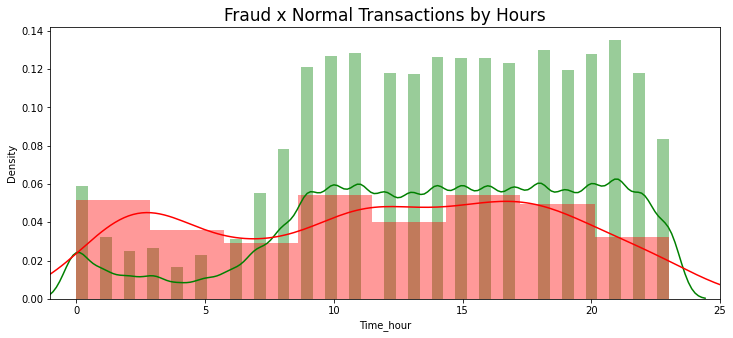

In [ ]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], 
             color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], 
             color='r')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

# **Scaling Amount and Time**

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount','Time_hour'], axis=1, inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# **Analyzing V's Features**

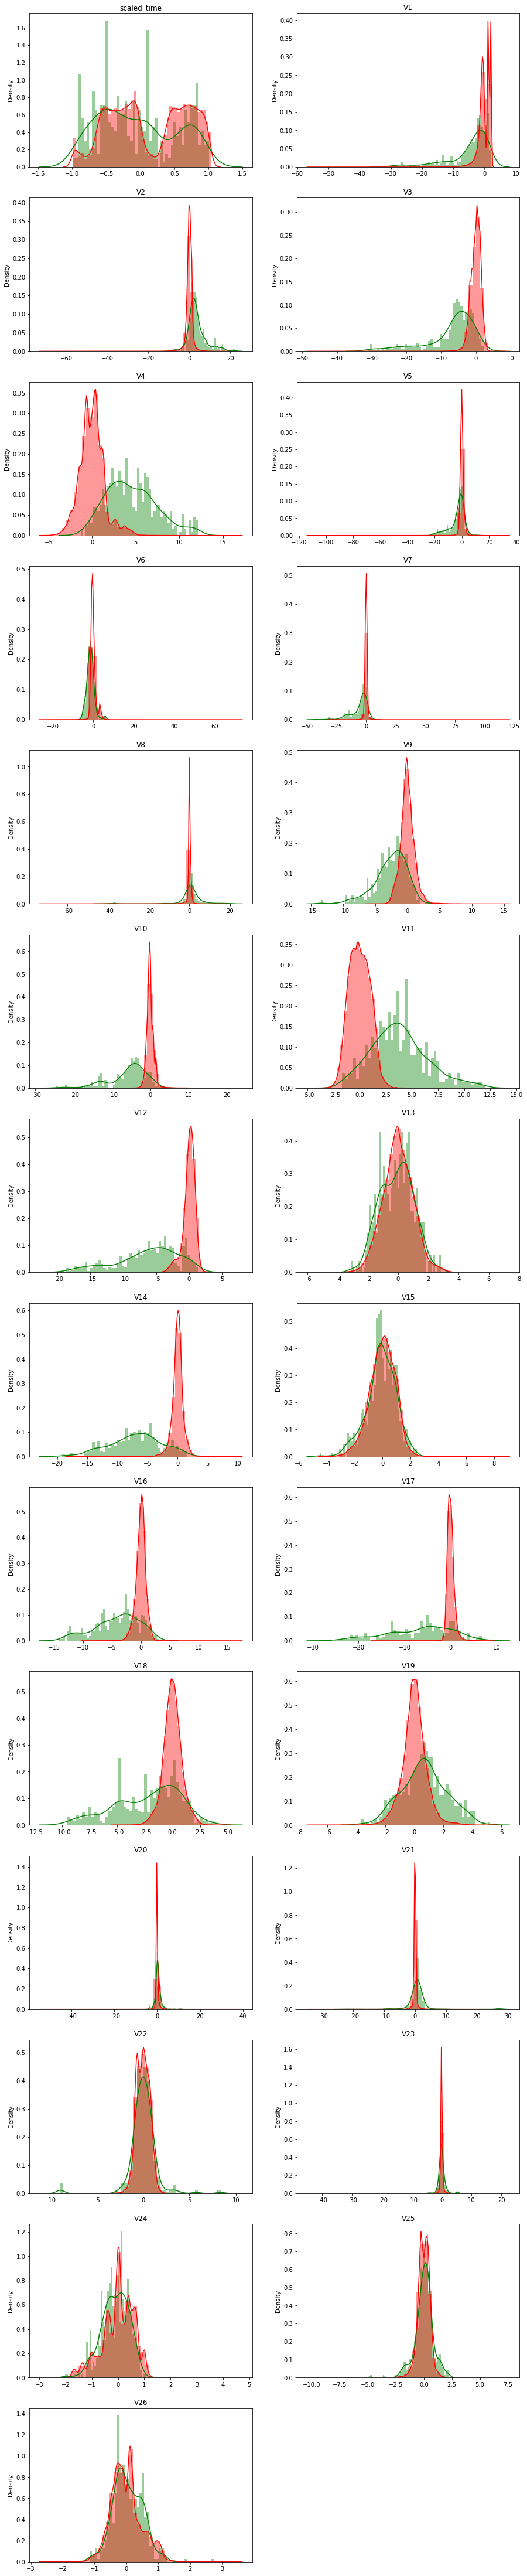

In [ ]:
import matplotlib.gridspec as gridspec
#Looking the V's features
columns = df.iloc[:,1:28].columns

frauds = df.Class == 1
normals = df.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
    sns.distplot(df[col][normals], bins = 50, color='r') #Will receive the "ocean" color
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()


# **Determining Corelation**

In [ ]:
df.corr()['Class'].sort_values()

V17             -0.326481
V14             -0.302544
V12             -0.260593
V10             -0.216883
V16             -0.196539
V3              -0.192961
V7              -0.187257
V18             -0.111485
V1              -0.101347
V9              -0.097733
V5              -0.094974
V6              -0.043643
scaled_time     -0.012323
V24             -0.007221
V13             -0.004570
V15             -0.004223
V23             -0.002685
V22              0.000805
V25              0.003308
V26              0.004455
scaled_amount    0.005632
V28              0.009536
V27              0.017580
V8               0.019875
V20              0.020090
V19              0.034783
V21              0.040413
V2               0.091289
V4               0.133447
V11              0.154876
Class            1.000000
Name: Class, dtype: float64

The observations made through studying the correlation matrices are:
<ul>
<li><b>Negative Correlations: </b>V14, V12, V10 and V16 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V4, V11, V2, V19 and V21 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
</ul>

**BoxPlots**: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

# **Box Plot - To Understand Negatively Correlated Features**


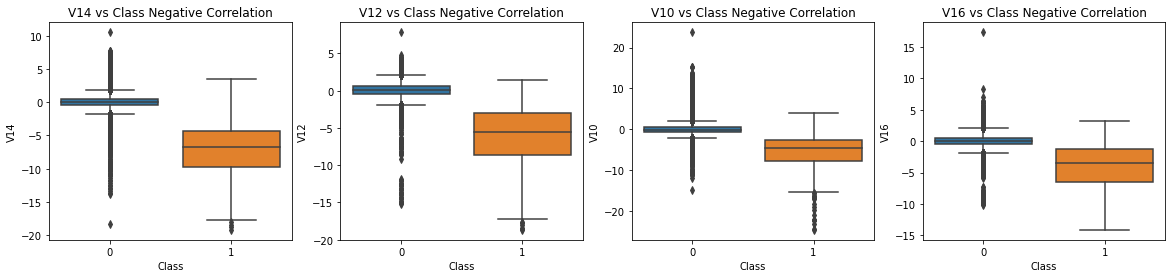

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

l = ['V14', 'V12', 'V10', 'V16']

for i in range(4):
    sns.boxplot(x='Class', y=l[i], data=df, ax=axes[i])
    axes[i].set_title(f'{l[i]} vs Class Negative Correlation')

plt.show()

# **Box Plot - To Understand Positively Correlated Features**


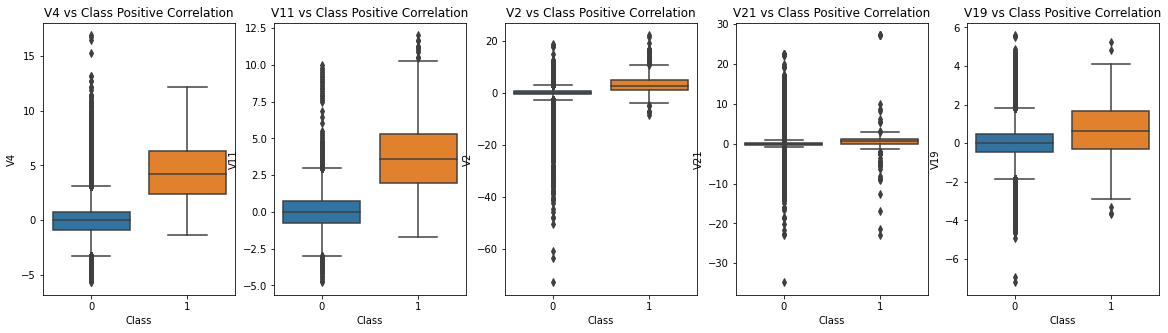

In [ ]:
f, axes = plt.subplots(ncols=5, figsize=(20,5))

l = ['V4', 'V11', 'V2', 'V21', 'V19']

for i in range(5):
    sns.boxplot(x='Class', y=l[i], data=df, ax=axes[i])
    axes[i].set_title(f'{l[i]} vs Class Positive Correlation')

plt.show()

In [ ]:
def recursive_fs(data,X_train_non_scaled,n,type):
   X_train = data["X_train"]
   X_test = data["X_test"]
   y_train = data["y_train"]
   y_test = data["y_test"]
   estimator = DecisionTreeClassifier()
   selector = RFE(estimator, n_features_to_select=n, step=1)
   selector = selector.fit(X_train, y_train.values.ravel())
   selected_feat = X_train_non_scaled.columns[(selector.get_support())]
   print(f"Features Selected By {type}: {selected_feat}")
   return selector.transform(X_test), selector.transform(X_train)



#This function is used select most important feature from the Dataset provided the classification model.
def feature_selection(data,X_train_non_scaled,model,type):
  X_train = data["X_train"]
  X_test = data["X_test"]
  y_train = data["y_train"]
  y_test = data["y_test"]
  sel_ = SelectFromModel(model)
  sel_.fit(X_train, y_train.values.ravel())
  selected_feat = X_train_non_scaled.columns[(sel_.get_support())]
  print(f"Features Selected By {type}: {selected_feat}")
  return sel_.transform(X_test), sel_.transform(X_train)

#This function fits different models on the Dataset. It checks what algrithm to select based on the Dataset Object provided as a parameter.
def compare_algorithms(X_train,Y_train,X_test,Y_test,method,dataset_object):
    reduction_type = method
    algos = dataset_object['ALGORITHMS'];
    data_prediction_type = dataset_object["TYPE"]

    for algo in algos:
      if algo == ALGORITHMS["RANDOM_FOREST"] and data_prediction_type == "Classification":
          kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
          model = RandomForestClassifier(max_depth = 2, random_state = 0)
          result_auc = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')
          result_accuracy = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
          print(f"Results for Type = {reduction_type} | Model = {algo}")
          print(f"Accuracy: {result_accuracy.mean()}")
          print(f"ROC AUC: {result_auc.mean()}")
          print(100*"=")

      if algo == ALGORITHMS["XGBOOST"] and data_prediction_type == "Classification":
          kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
          model = XGBClassifier()
          result_auc = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')
          result_accuracy = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
          print(f"Results for Type = {reduction_type} | Model = {algo}")
          print(f"Accuracy: {result_accuracy.mean()}")
          print(f"ROC AUC: {result_auc.mean()}")
          print(100*"=")

     
      if algo == ALGORITHMS["LINEAR_REGRESSION"] and data_prediction_type == "Regression":
          print(f"Results of:{algo}")
          model = LinearRegression()
          model.fit(X_train, Y_train)
          y_pred = model.predict(X_test)
          print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
          print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
          print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
          print(100*"=")

      if algo == ALGORITHMS["VOTING_REGRESSION"] and data_prediction_type == "Regression":
          print(f"Results of:{algo}")
          regressor1 = LinearRegression()
          regressor2 = RandomForestRegressor(n_estimators=100, random_state=1)
          model = VotingRegressor([('lr', regressor1), ('rf', regressor2)])
          model.fit(X_train,Y_train)
          y_pred = model.predict(X_test)
          print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
          print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
          print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
          print(100*"=")
  



def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

def get_n_components(data):
   print("LDA:Getting Components")
   lda = LDA(n_components=None)
   X_train = lda.fit(data["X_train"],data['y_train'].values.ravel())
   lda_var_ratios = lda.explained_variance_ratio_
   n = select_n_components(lda_var_ratios, 0.90)
   print(f"Best Number Of Components For LDA: {n}")
   return n


def do_TSNE(n,data):
  tsne = TSNE(n_components = 2, random_state = 0)
  X_train = tsne.fit_transform(data["X_train"])
  y_train = data["y_train"];
  tsne_df = pd.DataFrame(X_train)
  tsne_df['Classification'] = y_train
  tsne_df.columns = ['X','Y','Classification']
  plt.figure(figsize = (10,10))
  sns.scatterplot(x= "X",y="Y", hue = 'Classification', legend = 'full', data = tsne_df)
  plt.show()
  
def start_comparison(dataset_object):
  df = dataset_object["DATAFRAME"](dataset_object["URL"])
  data_prediction_type = dataset_object["TYPE"]
  X = df.iloc[:, :-1]
  y = df.iloc[: , -1:]
  X_train_non_scaled, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state= 0)
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train_non_scaled)
  X_test = sc.transform(X_test)
  data = {
        "X_train":X_train, 
        "X_test":X_test, 
        "y_train":y_train, 
        "y_test":y_test
    }
  print(f"Training Data Shape Before Applying FS or DR {X_train.shape}")

  for method in DR:
    if method == DR["PCA"]:
      reduction_type = "PCA"
      pca = PCA(dataset_object["N_COMPONENTS"])
      X_train = pca.fit_transform(data["X_train"])
      X_test = pca.transform(data["X_test"])
      Y_train = data["y_train"]
      print(f"Training Data Shape After Applying PCA {X_train.shape}")
      compare_algorithms(X_train,Y_train.values.ravel(),X_test,y_test,method,dataset_object)

    if method == DR["LDA"] and data_prediction_type == "Classification":
      n = get_n_components(data)
      lda = LDA(n_components=n)
      X_train = lda.fit_transform(data["X_train"],data['y_train'].values.ravel())
      X_test = lda.transform(data["X_test"])
      Y_train = data["y_train"]
      compare_algorithms(X_train,Y_train.values.ravel(),X_test,y_test,method,dataset_object)

    if method == DR["L1"] and data_prediction_type == "Classification":
      X_test,X_train  = feature_selection(data,X_train_non_scaled,LogisticRegression(random_state = 0,solver = 'liblinear', multi_class= 'auto'),method)
      Y_train = data["y_train"]
      compare_algorithms(X_train,Y_train.values.ravel(),X_test,y_test,method,dataset_object)

    if method == DR["RF"] and data_prediction_type == "Classification":
      X_test,X_train  = feature_selection(data,X_train_non_scaled,RandomForestClassifier(n_estimators=100),method)
      Y_train = data["y_train"]
      compare_algorithms(X_train,Y_train.values.ravel(),X_test,y_test,method,dataset_object)

    if method == DR["XG"] and data_prediction_type == "Classification":
      X_test,X_train  = feature_selection(data,X_train_non_scaled,XGBClassifier(),method)
      Y_train = data["y_train"]
      compare_algorithms(X_train,Y_train.values.ravel(),X_test,y_test,method,dataset_object)

    if method == DR["RFS"] and data_prediction_type == "Classification":
      n = dataset_object["FEATURES"]
      X_test,X_train  = recursive_fs(data,X_train_non_scaled,n,method)
      Y_train = data["y_train"]
      compare_algorithms(X_train,Y_train.values.ravel(),X_test,y_test,method,dataset_object)  
        








In [ ]:

DATASETS = {
    
            "CARD_FRAUD":{
            "TYPE":"Classification",
            "N_COMPONENTS":5,
            "FEATURES":5,
            "URL": DATA_SETS_LINKS["CARD_FRAUD"],
            "DATAFRAME":lambda x:read_dataframe_from_drive(x),
            "PERFORM": lambda:start_comparison(DATASETS["CARD_FRAUD"]),
            "ALGORITHMS":[ALGORITHMS["XGBOOST"],ALGORITHMS["RANDOM_FOREST"],ALGORITHMS["LOGISTIC_REGRESSION"]]
            }
            
            }


In [ ]:
DATASETS["CARD_FRAUD"]["PERFORM"]()


Reading data set from Drive:creditcard.csv
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]
Training Data Shape Before Applying FS or DR (142403, 30)
Training Data Shape After Applying PCA (142403, 5)
Results for Type = PCA | Model = XGBOOST
Accuracy: 0.9987078883450143
ROC AUC: 0.9590920161951866
Results for Type = PCA | Model = RANDOM_FOREST
Accuracy: 0.9986025542250616
ROC AUC: 0.9046502129

### **Analysis on above:**
The above results shows mix results when ran different models on the same dataset. I have used different techniques of Dimensionality Reduction and Feature Selection.

When 3 components were selected using PCA, the accuracy is almost 90%. This means the top 5 components explains much about the overall dataset. 

When these components were fitted to XGBoost and Random Forest Classifiers, XGBoost worked slightly well as compared to Random Forest. The reason why XGBoost worked well comparatively:

i) Parallel creation of trees.
ii) Trees pruning using depth-first approach.
iii) Out-of-core computing.
iv) Regularization to avoid overfitting.
v) Handle missing values using sparse approach.
vi) inbuilt cross validation. 


On the other hand, LDA has chosen only one component out of 31. If you look at the accuracy of the models, they are akmost above 90%.

If we talk about feature selection approach, again, XGBoost Classifier worked well when selecting the most important features. XGBoost Classifier has selected less number of features and has high accuracy overall if you see the output above.

XGBoost minimises a regularised (L1 and L2) objective function that incorporates a function of convex loss and a model complexity penalty term.
In order to make the final prediction, the training continues iteratively, inserting new trees that predict the residuals or errors of previous trees which are then combined with previous trees. It's called gradient boosting. It also uses a gradient descent algorithm to minimise the loss.

Recursive feature selection is an iterative approach and selects features based on the ranking. This method is slow as compared to other feature selection methods but effective. Here 3 best features were selected by RFS, lesser than XGBoost FS method, where XGBoost outperformed RFS. This is because we have selected lesser number of features from RFS. If we increase number of features, the accuracy will increase as more features can help predict the target variable.




1.   Winner for feature selection => XGBoost

2.   Best Classifier on above => XGBoost

3.   Winner for Dimensionality Reduction => LDA










# **MCMC**

In [ ]:
# import theano
# import pymc3 as pm
# from pymc3.variational.callbacks import CheckParametersConvergence
# import statsmodels.formula.api as smf
# import arviz as az
# !wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh

# !chmod +x Anaconda3-5.1.0-Linux-x86_64.sh

# !bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

# import sys

# sys.path.append('/usr/local/lib/python3.6/site-packages/')

# #install theano and pygpu
# !conda install theano pygpu

In [ ]:
df = DATASETS["CARD_FRAUD"]["DATAFRAME"](DATA_SETS_LINKS["CARD_FRAUD"])

Reading data set from Drive:creditcard.csv
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


EDA showed that the most important features could be the following:
V14, V12, V10, V16, V4, V11, V2, V19 and V21

Distribution Of Each Variable

In [ ]:
imp_features_neg_corr = ['V14', 'V12', 'V10', 'V16']
imp_features_pos_corr = ['V4', 'V11', 'V2', 'V21']

# **Distribution of negatively corelated featues**

Plotting for column V14


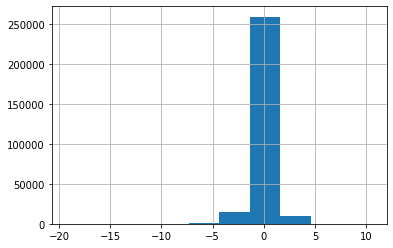

Plotting for column V12


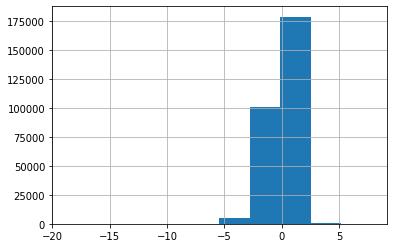

Plotting for column V10


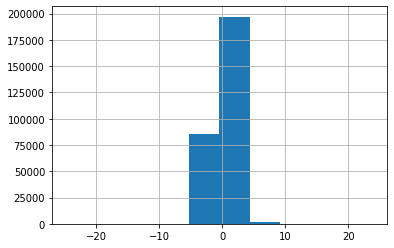

Plotting for column V16


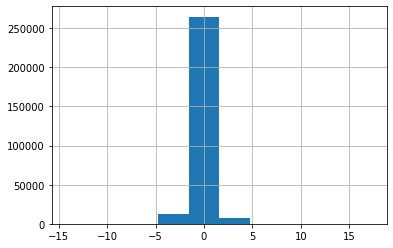

In [ ]:
for col in imp_features_neg_corr:
    hist = df[col].hist(bins=10)
    print("Plotting for column {}".format(col))
    plt.show()

# **Distribution of positively corelated featues**

Plotting for column V4


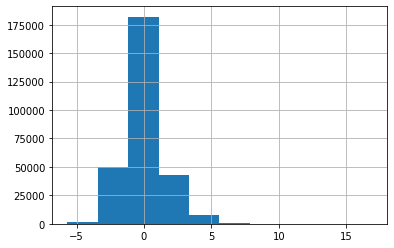

Plotting for column V11


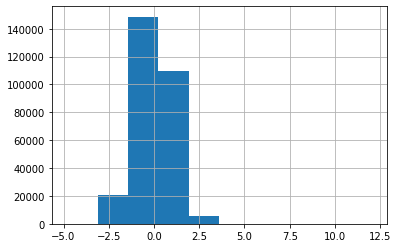

Plotting for column V2


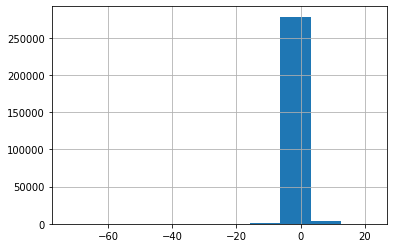

Plotting for column V21


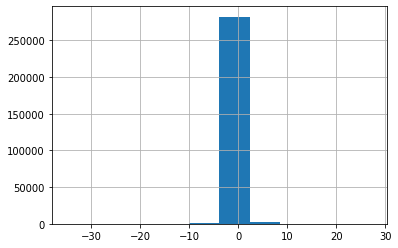

In [ ]:
for col in imp_features_pos_corr:
    hist = df[col].hist(bins=10)
    print("Plotting for column {}".format(col))
    plt.show()

# Define Model Definition

In [ ]:
#We will following model to illustrate Markov chain Monte Carlo inference:

data = df[imp_features_neg_corr + imp_features_pos_corr + ['Class']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284807 entries, 0 to 284806
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V14     284807 non-null  float64
 1   V12     284807 non-null  float64
 2   V10     284807 non-null  float64
 3   V16     284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V11     284807 non-null  float64
 6   V2      284807 non-null  float64
 7   V21     284807 non-null  float64
 8   Class   284807 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 21.7 MB


In [ ]:
#full_model = 'Class ~ V14 + V12 + V10 + V16 + V4 + V11 + V2  + V21'
full_model = 'Class ~ V14 + V21'
priors = {"Intercept": pm.Normal.dist(mu=0, sd=100),
          "Regressor": pm.Laplace.dist(mu=0, b=np.sqrt(2))
          }
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial(),priors = priors)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [ ]:
logistic_model.free_RVs

[Intercept ~ Normal, V14 ~ Laplace, V21 ~ Laplace]

The Laplace distribution is used for modeling in signal processing, various biological processes, finance, and economics. Examples of events that may be modeled by Laplace distribution include:

Credit risk and exotic options in financial engineering

Hamiltonian Monte Carlo – going NUTS
By default, PyMC3 automatically selects the most efficient sampler and initializes the sampling process for efficient convergence. For a continuous model, PyMC3 chooses the NUTS sampler.

Hamiltonian Monte Carlo (HMC) is a hybrid method that leverages the first-order derivative information of the gradient of the likelihood to propose new states for exploration and overcome some of the challenges of MCMC. In addition, it incorporates momentum to efficiently jump around the posterior. As a result, it converges faster to a high-dimensional target distribution than simpler random-walk Metropolis or Gibbs sampling.

To see what the convergence looks like, we first draw  500  samples after tuning the sampler for  500 iterations that will be discarded. The sampling process can be parallelized for multiple chains using the cores argument (except when using GPU).

# **Load already trained trace from drive**

In [ ]:
from pathlib import Path
import pickle
#get model
model_loaded = False
try:
  model_path = Path('models')
  with open(model_path / 'logistic_model_mh.pkl', 'rb') as buff:
      data0 = pickle.load(buff)  
  logistic_model, trace = data0['model'], data0['trace']
  model_loaded = True
except(e):
  print(e)




# **If trace not exist, then apply mcmc and store to drive**

In [ ]:
if model_loaded == False:
  with logistic_model:
    trace = pm.sample(tune=500,
                         draws=500,
                         chains=2,
                         init = 'adapt_diag',
                         cores=4)
    

  data_path = Path('data')
  fig_path = Path('figures')
  model_path = Path('models')
  for p in [data_path, fig_path, model_path]:
      if not p.exists():
          p.mkdir()


  with open(model_path / 'logistic_model_mh.pkl', 'wb') as buff:
      pickle.dump({'model': logistic_model, 'trace': trace}, buff)



In [ ]:
pm.summary(trace)


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-8.107,0.106,-8.308,-7.917,0.005,0.003,496.0,544.0,1.0
V14,-1.153,0.025,-1.204,-1.110,0.001,0.001,424.0,441.0,1.0
V21,0.081,0.048,-0.001,0.180,0.002,0.002,498.0,564.0,1.0


The Rhat function produces R-hat convergence diagnostic, which compares the between- and within-chain estimates for model parameters and other univariate quantities of interest. Here R_Hat is less than 1.05 so we can use this sample chain for model parameter estimation.

Bulk-ESS is useful measure for sampling efficiency in the bulk of the distribution (related e.g. to efficiency of mean and median estimates), and is well defined even if the chains do not have finite mean or variance.

Both bulk-ESS and tail-ESS should be at least 100 (approximately) per Markov Chain in order to be reliable and indicate that estimates of respective posterior quantiles are reliable.



In [ ]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Intercept  1000 non-null   float64
 1   V14        1000 non-null   float64
 2   V21        1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



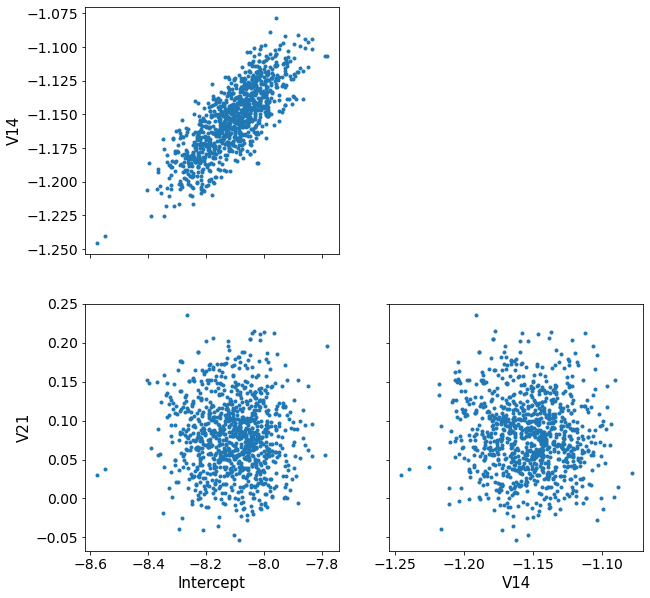

In [ ]:
az.plot_pair(trace, figsize=(10, 10));

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



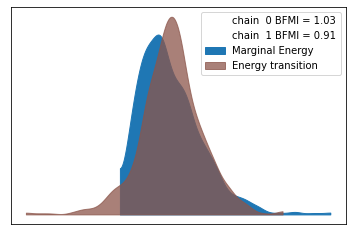

In [ ]:
pm.energyplot(trace);


We want the two distribution (energy and energy transition) as close as possible. If you have the energy transition distribution (diff(Energy)) much more narrow than energy distribution, it means you dont have enough energy to explore the whole parameter space and your posterior estimation is likely biased.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



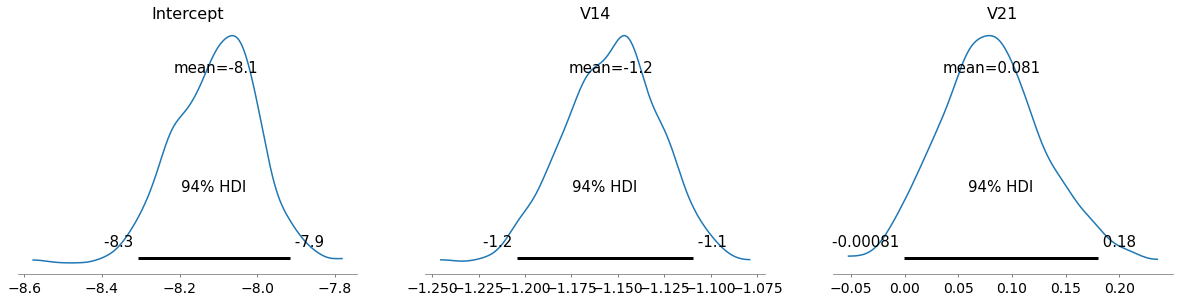

In [ ]:
pm.plot_posterior(trace);


In [ ]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=logistic_model)


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning:

samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample



In [ ]:
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve)

y_score = np.mean(ppc['y'], axis=0)
pred_scores = dict(y_true=df.Class,y_score=y_score)
roc_auc_score(**pred_scores)


0.9388926086647569

ROC AUC score is almost same as ML models. The power of MCMC is, we can draw posterior distribution with less number of features. Here, we used only 2 features and the accuracy is almost same as ML models used above. The drawback of MCMC is it takes a lots of time to sample the best chain.
